N = 15 , d = 10 , on_obs = 5000 , iter = 200 , sample transitions from observed transitions only

# init

In [26]:
import pandas  as pd
import pickle
import matplotlib.pyplot
import sys
import numpy as np

In [2]:
sys.path.append('C:\Repos\WhoCell\who_cell')
sys.path.append('C:\Repos\WhoCell')
sys.path.append('C:\Repos\WhoCell\who_cell\experiments')
sys.path.append('C:/Repos/WhoCell/who_cell/models')
sys.path.append('C:\Repos\pomegranate')

import transitions_dict
import who_cell
from gibbs_experiments import GibbsExperiment
from gibbs_sampler import GibbsSampler

# load data

In [3]:
#some results from the run
with open ('results.pkl','rb') as f : 
    [all_states, all_observations_sum, all_transitions, all_mues, all_ws] = pickle.load(f)

In [4]:
#few mathods we rewrite

def compare_transitions_prob_to_count(transitions_prob,transitions_count,n_traj,N,d):

    #the previous mathods need states as tuple and not str
    transitions_prob = {eval(k):{eval(kk):vv for kk,vv in v.items() } for k,v in transitions_prob.items()}
    transitions_count = {eval(k): {eval(kk): vv for kk, vv in v.items()} for k, v in transitions_count.items()}

    states = transitions_prob.keys()
    start_prob = self._build_start_prob(transitions_prob,N,d)
    prior = self._fwd_bkw(states, start_prob, transitions_prob, None, N, d, only_forward = True)

    _transitions_prob_to_count_list = []
    for _from_state,_to_states in transitions_prob.items() :
        for _to_state,prob in _to_states.items() :
            _from_prior = prior[_from_state[1]][_from_state]
            _to_prior = _from_prior * prob
            expected_trans_count = _to_prior * n_traj
            trans_count = transitions_count[_from_state][_to_state]

            _transitions_prob_to_count_list.append([str(_from_state),str(_to_state),expected_trans_count,trans_count])

    compr_df = pd.DataFrame(columns=['from','to','expected_count','count'],data = _transitions_prob_to_count_list)

    return compr_df

def build_final_transitions_compr(all_transitions) :
    if type(all_transitions) is list :
        _all_transitions_states_as_string = [{str(k).replace(' ',''):{str(kk).replace(' ',''):vv for kk,vv in v.items()}
                                              for k,v in _transition.items()} for _transition in all_transitions]
        _full_transitions_from_sampler = reduce(lambda a, b: {k: (Counter(a[k]) + Counter(b[k])) for k, _ in a.items()},
                                                _all_transitions_states_as_string)
    else :
        _full_transitions_from_sampler = {
            str(k).replace(' ', ''): {str(kk).replace(' ', ''): vv for kk, vv in v.items()} for k, v in
            all_transitions.items()}

    _normalized_full_transitions_from_sampler = \
        {k: {kk: (vv / sum(v.values())) for kk, vv in v.items()} for k, v in _full_transitions_from_sampler.items()}
  
    _full_transitions_from_sampler = \
        {k: {kk: vv for kk, vv in v.items()} for k, v in _full_transitions_from_sampler.items()}
   
    return _normalized_full_transitions_from_sampler, _full_transitions_from_sampler

  

In [5]:
#params of the run
N = 15
d = 10 
number_of_smapled_traj = 5000

sampler = GibbsSampler(N, d,[])

now we will build 3 comparisions - 1.all transitions 2. only obsarved trans 3. only null transitions

In [6]:
sampled_transitions = all_transitions[-2]
sampled_mues = all_mues[-1]


all transitions

In [7]:
all_normalized_sampled_transitions, all_sampled_transitions = build_final_transitions_compr(
    sampled_transitions)

all_transitions_prob_to_count = sampler.compare_transitions_prob_to_count(
                                          transitions_prob=all_normalized_sampled_transitions,
                                          transitions_count=all_sampled_transitions,
                                          n_traj = number_of_smapled_traj,N = N,d = d)


obsarved transitions

In [8]:
observed_normalized_sampled_transitions, observed_sampled_transitions = build_final_transitions_compr(
    sampled_transitions.observed_transitions_dict)

observed_transitions_prob_to_count = sampler.compare_transitions_prob_to_count(
                                          transitions_prob=observed_normalized_sampled_transitions,
                                          transitions_count=observed_sampled_transitions,
                                          n_traj = number_of_smapled_traj,N = N,d = d)


null transitions

In [9]:
null_normalized_sampled_transitions, null_sampled_transitions = build_final_transitions_compr(
    sampled_transitions.null_transitions_dict)

null_transitions_prob_to_count = sampler.compare_transitions_prob_to_count(
                                          transitions_prob=null_normalized_sampled_transitions,
                                          transitions_count=null_sampled_transitions,
                                          n_traj = number_of_smapled_traj,N = N,d = d)


combined transitions

In [10]:
_tmp = all_transitions_prob_to_count.merge(null_transitions_prob_to_count,left_on=['from','to'],right_on=['from','to'],suffixes=['_all','_null']).copy(deep=True)
combined_transitions_prob_to_count = _tmp.merge(observed_transitions_prob_to_count,left_on=['from','to'],right_on=['from','to'],suffixes=['_','_obsarved'])
combined_transitions_prob_to_count

,from,to,expected_count_all,count_all,expected_count_null,count_null,expected_count,count
0,"(0, 0)","(9, 1)",155.080960,1111,155.632985,536,154.569892,575
1,"(0, 0)","(4, 1)",156.476829,1121,153.600465,529,159.139785,592
2,"(0, 0)","(5, 1)",125.069793,896,121.370499,418,128.494624,478
3,"(0, 0)","(7, 1)",9.352317,67,9.581882,33,9.139785,34
4,"(0, 0)","(6, 1)",10.329425,74,10.743322,37,9.946237,37
...,...,...,...,...,...,...,...,...
1079,"(9, 13)","(9, 14)",46.800000,52,39.977913,22,52.370657,30
1080,"(9, 13)","(0, 14)",36.000000,40,36.343557,20,34.913771,20
1081,"(9, 13)","(7, 14)",31.500000,35,39.977913,22,22.693951,13
1082,"(9, 13)","(8, 14)",26.100000,29,30.892024,17,20.948263,12


known and sampled

In [11]:
normalized_transitions_comper_df = pd.read_pickle("normalized_transitions_comper_df")
transitions_comper_df = pd.read_pickle("transitions_comper_df")

In [12]:
combined_transitions_prob_to_count['from']= combined_transitions_prob_to_count['from'].apply(lambda x:x.replace(' ',''))
combined_transitions_prob_to_count['to']  = combined_transitions_prob_to_count['to'].apply(lambda x:x.replace(' ',''))

In [13]:
sampled =  transitions_comper_df[['from','to','value_sampled']].copy(deep=True)

# analysis

build data

In [14]:
normalized_transitions_comper_df['null_transition'] = (normalized_transitions_comper_df['value_known'] == 0) & (normalized_transitions_comper_df['value_sampled'] != 0)

In [15]:
raw_for_analysis = sampled.merge(combined_transitions_prob_to_count,left_on=['from','to'],right_on=['from','to'])
raw_for_analysis = raw_for_analysis.merge( normalized_transitions_comper_df[['from','to','null_transition']],left_on=['from','to'],right_on=['from','to'])

In [16]:
raw_for_analysis['error_all'] = ((raw_for_analysis['expected_count_all'] - raw_for_analysis['count_all']))
raw_for_analysis['error_null'] = ((raw_for_analysis['expected_count_null'] - raw_for_analysis['count_null']))
raw_for_analysis['error_obsarved'] = ((raw_for_analysis['expected_count'] - raw_for_analysis['count']))



raw_for_analysis = raw_for_analysis.sort_values('value_sampled',ascending=False)
raw_for_analysis['color'] = raw_for_analysis['null_transition'].apply(lambda x:'red' if x else 'green')

## analysis

In [17]:
raw_for_analysis


,from,to,value_sampled,expected_count_all,count_all,expected_count_null,count_null,expected_count,count,null_transition,error_all,error_null,error_obsarved,color
0,"(0,0)","(4,1)",595.0,156.476829,1121,153.600465,529,159.139785,592,False,-964.523171,-375.399535,-432.860215,green
2,"(0,0)","(9,1)",571.0,155.080960,1111,155.632985,536,154.569892,575,False,-955.919040,-380.367015,-420.430108,green
1,"(0,0)","(5,1)",481.0,125.069793,896,121.370499,418,128.494624,478,False,-770.930207,-296.629501,-349.505376,green
105,"(9,1)","(3,2)",183.0,369.521351,353,357.479982,175,380.745800,178,False,16.521351,182.479982,202.745800,green
104,"(9,1)","(5,2)",182.0,392.551010,375,373.821924,183,410.692099,192,False,17.551010,190.821924,218.692099,green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,"(0,2)","(3,3)",2.0,8.257829,7,4.479317,2,12.461054,5,True,1.257829,2.479317,7.461054,red
229,"(5,11)","(5,12)",2.0,6.300000,7,5.587430,3,6.910420,4,True,-0.700000,2.587430,2.910420,red
136,"(2,10)","(4,11)",2.0,9.000003,10,14.467178,8,3.595237,2,True,-0.999997,6.467178,1.595237,red
785,"(3,6)","(4,7)",2.0,7.199887,8,5.554654,3,8.656709,5,True,-0.800113,2.554654,3.656709,red


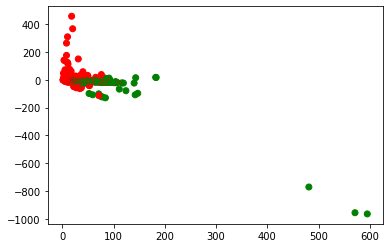

In [28]:
matplotlib.pyplot.scatter(raw_for_analysis['value_sampled'],
                          raw_for_analysis['error_all'],
                         color = raw_for_analysis['color'])


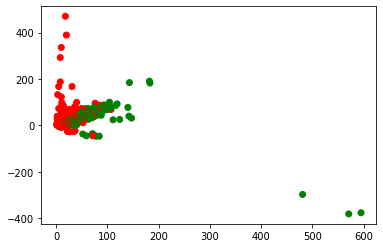

In [31]:
matplotlib.pyplot.scatter(raw_for_analysis['value_sampled'],
                          raw_for_analysis['error_null'],
                         color = raw_for_analysis['color'])


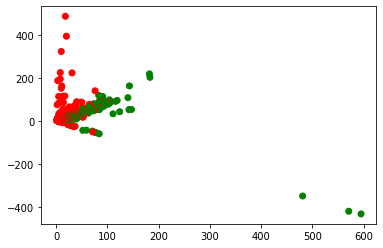

In [23]:
matplotlib.pyplot.scatter(raw_for_analysis['value_sampled'],
                          raw_for_analysis['error_obsarved'],
                         color = raw_for_analysis['color'])


In [ ]:
matplotlib.pyplot.scatter(raw_for_analysis['value_sampled'],
                          raw_for_analysis['error_all'],
                         color = raw_for_analysis['color'])


In [ ]:
tmp = raw_for_analysis[(raw_for_analysis['error'] < 0.6) & (raw_for_analysis['count'] < 120)]

matplotlib.pyplot.scatter(tmp['value_sampled'],
                          tmp['error'],
                         color = tmp['color'])


In [43]:
is_null_tran = normalized_transitions_comper_df[['from','to','null_transition']].copy(deep=True).set_index(['from','to']).to_dict()['null_transition']

In [44]:
is_null_tran

{('(0,0)', '(4,1)'): False,
 ('(0,0)', '(5,1)'): False,
 ('(0,0)', '(9,1)'): False,
 ('(0,0)', '(7,1)'): True,
 ('(0,0)', '(6,1)'): True,
 ('(0,0)', '(8,1)'): True,
 ('(0,0)', '(0,1)'): True,
 ('(0,0)', '(2,1)'): True,
 ('(0,0)', '(1,1)'): True,
 ('(1,0)', '(1,1)'): True,
 ('(1,0)', '(2,1)'): True,
 ('(1,0)', '(0,1)'): True,
 ('(1,0)', '(8,1)'): True,
 ('(1,0)', '(6,1)'): True,
 ('(1,0)', '(7,1)'): True,
 ('(1,0)', '(9,1)'): True,
 ('(1,0)', '(5,1)'): False,
 ('(1,0)', '(4,1)'): True,
 ('(2,0)', '(2,1)'): False,
 ('(2,0)', '(0,1)'): True,
 ('(2,0)', '(8,1)'): False,
 ('(2,0)', '(1,1)'): True,
 ('(2,0)', '(6,1)'): True,
 ('(2,0)', '(7,1)'): True,
 ('(2,0)', '(9,1)'): True,
 ('(2,0)', '(5,1)'): True,
 ('(2,0)', '(4,1)'): True,
 ('(3,0)', '(0,1)'): False,
 ('(3,0)', '(5,1)'): False,
 ('(3,0)', '(9,1)'): False,
 ('(3,0)', '(7,1)'): False,
 ('(3,0)', '(6,1)'): False,
 ('(3,0)', '(8,1)'): False,
 ('(3,0)', '(2,1)'): False,
 ('(3,0)', '(1,1)'): False,
 ('(3,0)', '(4,1)'): False,
 ('(4,0)', '(

In [46]:
a = sampled_transitions.observed_transitions_dict
b = sampled_transitions.null_transitions_dict

for k,v in a.items():
    for kk,vv in v.items():
        is_null_t = is_null_tran[(str(k).replace(' ',''),str(kk).replace(' ',''))]
        print((k,kk,vv,b[k][kk]),is_null_t)
        print('')
        

((0, 0), (4, 1), 592, 529) False

((0, 0), (5, 1), 478, 418) False

((0, 0), (9, 1), 575, 536) False

((0, 0), (7, 1), 34, 33) True

((0, 0), (6, 1), 37, 37) True

((0, 0), (8, 1), 24, 33) True

((0, 0), (0, 1), 21, 36) True

((0, 0), (2, 1), 70, 62) True

((0, 0), (1, 1), 29, 38) True

((0, 1), (2, 2), 8, 18) True

((0, 1), (0, 2), 9, 24) True

((0, 1), (7, 2), 14, 10) True

((0, 1), (5, 2), 21, 24) True

((0, 1), (3, 2), 13, 15) True

((0, 1), (8, 2), 2, 8) True

((0, 2), (7, 3), 43, 60) True

((0, 2), (8, 3), 36, 43) True

((0, 2), (0, 3), 52, 49) True

((0, 2), (9, 3), 14, 11) True

((0, 2), (4, 3), 16, 16) True

((0, 2), (6, 3), 10, 17) True

((0, 2), (2, 3), 39, 56) True

((0, 2), (1, 3), 27, 30) True

((0, 2), (3, 3), 5, 2) True

((0, 2), (5, 3), 11, 16) True

((0, 3), (5, 4), 33, 46) False

((0, 3), (6, 4), 29, 33) False

((0, 3), (3, 4), 62, 63) False

((0, 3), (7, 4), 49, 58) False

((0, 3), (9, 4), 37, 52) True

((0, 3), (4, 4), 29, 28) True

((0, 3), (8, 4), 34, 35) False



KeyError: (8, 5)